In [7]:
import os
dir_list = os.chdir('./../reverse-dynamics-nlp/')

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, GPTNeoXForCausalLM
import numpy as np
from prompt_optimizer import PromptOptimizer
from utils import get_reverse_pair, start_chunk_hf, forward_loss, reverse_tokenize
from utils import reverse_normalized_generate, reverse_normalized_beam_generate, forward_loss_batch, rand_init
from scipy import stats
from tqdm import tqdm


import pickle

In [4]:
with open('data/reversal_results_pile_val_160m_100sample.pkl', 'rb') as file:
  se_out = pickle.load(file)

In [49]:
se_out.keys()

dict_keys(['parameters'])

In [10]:
methods = list(se_out[next(iter(se_out))]["prompt_opts"].keys())
# methods.append("gt")


KeyError: 'prompt_opts'

In [95]:
for (k,v) in se_out.items():
  print("suffix:", k)
  for method in methods:
    if method == "gt":
        print("    ", "gt: ", v["gt_prefix"])
    else:
      print("    ", method, ": ", v["prompt_opts"][method]["prefix"])

suffix:  “Gas Jews die,” and “Gas the kikes.”
     gcg :  $$Gas Jerem persecution posters esHitDelete”— scream
     reverse_model :   out of gas when we run out of gas,”
     bayesian_reversal :   Jews,” “Gas Jews,” “Gas Jews,”
     gt:  Some recent examples from 2016 include, “Kill all kikes,”
suffix:  stab a Jewish person in a manner that ensures their speedy death.
     gcg :  asses aliveensure Sur […]stab 182 Jews Rough noun
     reverse_model :   we need to have an understanding of what it is to
     bayesian_reversal :   Orthodox Jew is carrying a knife in an attempt to
     gt:  A video being widely circulated in Palestinian social media networks teaches jihadists how to
suffix:  shooting deaths of Black citizens by police across the country.
     gcg :  ения {{idespread Black Citizen Tea Appelleeootingom and targeted
     reverse_model :  , earlier this week, in the wake of the
     bayesian_reversal :  . Thirteen Black protesters were arrested while protesting the
     gt:  Ca

In [76]:
def multi_arg_mean(*args,exp=False):
    data = np.array(args)
    if exp:
        return np.exp(np.mean(data))
    else:
        return np.mean(data)


# def summarize_methods(se_out):
summary_dict = {}
# methods = ["reverse_model", "gcg", "gt", "BayesianReversal(1B)", "BayesianReversal(410m)", "BayesianReversal(160m)"]
methods = ["reverse_model", "gcg", "gt", "bayesian_reversal"]
for method in methods:
    
  summary_dict[method] = {}
  prefix_losses = []
  suffix_losses = []
  for (k,v) in se_out.items():
    if k =="parameters":
      continue

    key_name = method
    if method != "gt":
      prefix_losses.append(v["prompt_opts"][key_name]["prefix_loss"])
      suffix_losses.append(v["prompt_opts"][key_name]["suffix_loss"])
    else:
      prefix_losses.append(v["gt_prefix_loss"])
      suffix_losses.append(v["gt_suffix_loss"])
  
  pl_array = np.array(prefix_losses)
  pl_mean = np.mean(pl_array)
  sl_array = np.array(suffix_losses)
  sl_mean = np.mean(sl_array)


  summary_dict[method]["prefix_loss"] = pl_array
  summary_dict[method]["suffix_loss"] = sl_array
  summary_dict[method]["prefix_loss_mean"] = pl_mean
  summary_dict[method]["suffix_loss_mean"] = sl_mean
  summary_dict[method]["num_samples"] = len(prefix_losses)

  pl_lb, pl_ub = stats.bootstrap((pl_array,), statistic=lambda x: multi_arg_mean(x,exp=False), confidence_level=0.95).confidence_interval
  summary_dict[method]["prefix_loss_95_bounds"] = (pl_lb, pl_ub)
  summary_dict[method]["prefix_loss_95_err"] = np.array((pl_mean - pl_lb, pl_ub - pl_mean)).reshape(2,1)

  sl_lb, sl_ub = stats.bootstrap((sl_array,), statistic=lambda x: multi_arg_mean(x,exp=False), confidence_level=0.95).confidence_interval
  summary_dict[method]["suffix_loss_95_bounds"] = (sl_lb, sl_ub)
  summary_dict[method]["suffix_loss_95_err"] = np.array((sl_mean - sl_lb, sl_ub - sl_mean)).reshape(2,1)

  pp_array = pl_array
  sp_array = -1.0*sl_array

  pp_mean = np.exp(np.mean(pp_array))
  sp_mean = np.exp(np.mean(sp_array))

  summary_dict[method]["prefix_prob_mean"] = pp_mean
  summary_dict[method]["suffix_prob_mean"] = sp_mean

  pp_lb, pp_ub = stats.bootstrap((pp_array,), statistic=lambda x: multi_arg_mean(x,exp=True), confidence_level=0.95).confidence_interval
  summary_dict[method]["prefix_prob_95_bounds"] = (pp_lb, pp_ub)
  summary_dict[method]["prefix_prob_95_err"] = np.array((pp_mean - pp_lb, pp_ub - pp_mean)).reshape(2,1)

  sp_lb, sp_ub = stats.bootstrap((sp_array,), statistic=lambda x: multi_arg_mean(x,exp=True), confidence_level=0.95).confidence_interval
  summary_dict[method]["suffix_prob_95_bounds"] = (sp_lb, sp_ub)
  summary_dict[method]["suffix_prob_95_err"] = np.array((sp_mean - sp_lb, sp_ub - sp_mean)).reshape(2,1)





  


  


In [81]:
# unsqueeze at last dimension numpy array
print(summary_dict["gcg"]["prefix_prob_mean"])
print(summary_dict["gcg"]["prefix_prob_95_bounds"])


print(summary_dict["gcg"]["prefix_loss_mean"])
print(summary_dict["gcg"]["prefix_loss_95_bounds"])


2.6243625737720385e-12
(3.2778752237986055e-14, 9.264048761811067e-11)
26.66618307841193
(23.02098934581463, 30.839514857920136)


In [87]:
for (k,v) in summary_dict.items():
  # prefix_interval_95 = 1.96 * v["prefix_loss_std"] / (v["num_samples"] ** 0.5)
  # suffix_interval_95 = 1.96 * v["suffix_loss_std"] / (v["num_samples"] ** 0.5)
  # print prefix and suffix mean +- confidence interval format to 3 digits
  print(f"{k} prefix loss: {v['prefix_prob_mean']:.3f}")
  print(f"{k} suffix loss: {v['suffix_prob_mean']:.3f} ")






reverse_model prefix loss: 0.043
reverse_model suffix loss: 0.051 
gcg prefix loss: 0.000
gcg suffix loss: 0.065 
gt prefix loss: 0.018
gt suffix loss: 0.049 
bayesian_reversal prefix loss: 0.026
bayesian_reversal suffix loss: 0.048 


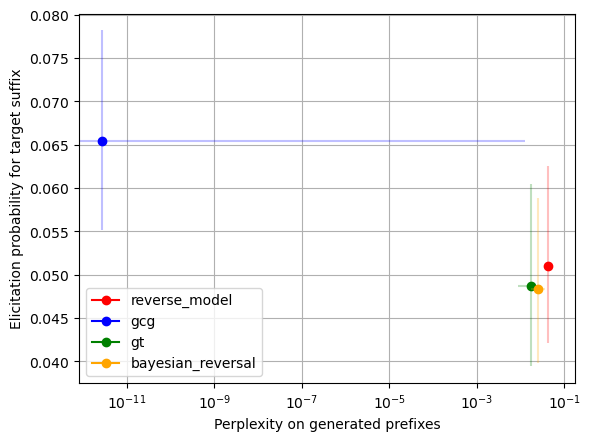

In [84]:
# Plotting GCG
import matplotlib.pyplot as plt
plt.figure()
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for (i,(k,v)) in enumerate(summary_dict.items()):

  # loss 
  # plt.plot(v["prefix_loss_mean"], v["suffix_loss_mean"], marker='o', label=k, color = colors[i])
  # plt.errorbar(v["prefix_loss_mean"], v["suffix_loss_mean"], yerr=v["suffix_loss_95_err"], xerr=v["prefix_loss_95_err"], alpha=0.25, color=colors[i])

  # probs
  plt.plot(v["prefix_prob_mean"], v["suffix_prob_mean"], marker='o', label=k, color = colors[i])
  plt.errorbar(v["prefix_prob_mean"], v["suffix_prob_mean"], yerr=v["suffix_prob_95_err"], xerr=v["suffix_prob_95_err"], alpha=0.25, color=colors[i])

  #RLM
#   if spacing:
#       max_idx = len(mean_prefix_losses) - 1
#       indices = [0]+[int(2**i) for i in range(int(np.log2(max_idx)) + 1) if 2**i <= max_idx]
#       if max_idx not in indices: indices.append(max_idx)
#   else:
#       indices = range(len(mean_prefix_losses))

#   # Plot using the exponential indices
#   plt.plot([mean_prefix_losses[i] for i in indices], [mean_suffix_losses[i] for i in indices], marker='v', label='Reverse LM varying number of beams')
#   plt.errorbar([mean_prefix_losses[i] for i in indices], [mean_suffix_losses[i] for i in indices], yerr=np.array([suffix_errors[:,i] for i in indices]).T, xerr=np.array([prefix_error[:,i] for i in indices]).T, alpha=0.25, color='red')

  # plt.plot(mean_prefix_losses[::spacing], mean_suffix_losses[::spacing], marker='v', label='Reverse LM varying number of beams')
  # plt.errorbar(mean_prefix_losses[::spacing], mean_suffix_losses[::spacing], yerr=suffix_errors[:,::spacing], xerr=prefix_error[:,::spacing], alpha=0.15, color='red')
#   plt.plot([mean_prefix_losses[0]], [mean_suffix_losses[0]], marker='x', linestyle='', color='green', label='Greedy Prefix')

plt.xlabel('Perplexity on generated prefixes')
plt.ylabel('Elicitation probability for target suffix')
plt.xscale('log')
plt.legend(loc='lower left')#'best')
plt.grid(True)
plt.show()

1.4142135623730951

KeyError: 'reverse_model'

In [ ]:
#Load positional probs
sum_of_matrices = None
for i in range(30):  
    num = str(i).zfill(2)  # pad single digit numbers with a leading zero
    file_path = f'/home/jp6263/reverse-dynamics-nlp/pos_counts_10_{num}.pt'
    matrix = torch.load(file_path)
    
    if sum_of_matrices is None:
        sum_of_matrices = matrix
    else:
        sum_of_matrices += matrix

# Initialize probabilities
completed_sum = sum_of_matrices.clone()
completed_sum[completed_sum == 0] = 1

completed_sum = sum_of_matrices.clone()
completed_sum[completed_sum == 0] = 1

inverse_dataset_probabilities = completed_sum.clone()
for col in range(inverse_dataset_probabilities.shape[1]):
    inverse_dataset_probabilities[:,col] = inverse_dataset_probabilities[:,col] / inverse_dataset_probabilities[:,col].sum()
inverse_dataset_probabilities = 1/inverse_dataset_probabilities
inverse_dataset_probabilities[50277:] = 1
inverse_dataset_probabilities[:2] = 1



positionless_inverse_probabilities = completed_sum.clone()
positionless_inverse_probabilities = positionless_inverse_probabilities.sum(dim=1)
positionless_inverse_probabilities = positionless_inverse_probabilities / positionless_inverse_probabilities.sum()
positionless_inverse_probabilities = 1/positionless_inverse_probabilities
positionless_inverse_probabilities = positionless_inverse_probabilities.unsqueeze(1).repeat(1, completed_sum.shape[1])
positionless_inverse_probabilities[50277:] = 1
positionless_inverse_probabilities[:2]=1
positionless_inverse_probabilities.shape

total_obs = torch.sum(completed_sum)
vocab_counts_alpha = completed_sum.sum(dim=1)
vocab_counts_beta = total_obs-vocab_counts_alpha
vocab_counts_beta = vocab_counts_beta + 5e4

positional_alpha = torch.zeros_like(completed_sum)
positional_beta = torch.zeros_like(completed_sum)
positional_alpha = vocab_counts_alpha.unsqueeze(1).repeat(1, completed_sum.shape[1])+completed_sum
positional_beta = vocab_counts_beta.unsqueeze(1).repeat(1, completed_sum.shape[1])+total_obs/10-completed_sum
smoothed_positional_inverse_probabilities = (positional_alpha-1)/(positional_alpha+positional_beta-2)
smoothed_positional_inverse_probabilities = 1/smoothed_positional_inverse_probabilities
smoothed_positional_inverse_probabilities[50277:,:] = torch.ones_like(smoothed_positional_inverse_probabilities[50277:,:])
smoothed_positional_inverse_probabilities[:2,:] = torch.ones_like(smoothed_positional_inverse_probabilities[:2,:])

In [ ]:
#Load models 
tokenizer = AutoTokenizer.from_pretrained("afterless/reverse-pythia-160m")
bwd_model = GPTNeoXForCausalLM.from_pretrained("afterless/reverse-pythia-160m").cuda()
model = GPTNeoXForCausalLM.from_pretrained("EleutherAI/pythia-160m", cache_dir='/scratch/jp6263/hf/models/').cuda()
tokenizer.eos_token = '<|endoftext|>'
tokenizer.pad_token = tokenizer.eos_token
# pile_test = load_dataset(path='/vast/work/public/ml-datasets/pile/', data_files='/vast/work/public/ml-datasets/pile/test.jsonl')


In [ ]:
#Nanda dataset
dataset = load_dataset("NeelNanda/pile-10k")
pairs = get_reverse_pair(dataset['train'], start_chunk_hf, tokenizer)
print(next(pairs))
nanda_list = list(pairs)

In [ ]:
#Define plotting functions
# Define plot GCG
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


def plot_gcg_pareto(all_losses, all_naturals, beam_size,):
    suffix_loss_mat = -1*np.array(all_losses).T
    prefix_loss_mat = -1*np.array(all_naturals).T
    mean_prefix_losses = np.mean(prefix_loss_mat, axis=0)
    prefix_error = get_errors(prefix_loss_mat, mean_prefix_losses, beam_size)
    mean_suffix_losses = np.mean(suffix_loss_mat, axis=0)
    suffix_errors = get_errors(suffix_loss_mat, mean_suffix_losses, beam_size)

# Plotting
    plt.figure()
    plt.plot(mean_prefix_losses, mean_suffix_losses, marker='o', label='Best-of-N')
    plt.errorbar(mean_prefix_losses, mean_suffix_losses, yerr=suffix_errors, xerr=prefix_error, alpha=0.25, color='red')
    plt.plot([mean_prefix_losses[0]], [mean_suffix_losses[0]], marker='x', linestyle='', color='red', label='Greedy Prefix')
    plt.xlabel(f'log P(p)')
    plt.ylabel('log P(s|p)')
    # plt.title(f'Num beams varies from 1 to {beam_size}, mean over {eval_size} samples')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Define plot beams
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plot_beams(all_losses, all_naturals, beam_size, normalizer_temp, base_prefix_loss=None, base_suffix_loss=None, probs=False):
    eval_size = len(all_losses)
    print(f'inverse dataset probs temp is {normalizer_temp}')

    prefix_loss_at_n, best_suffix_loss_at_n = [[loss[0]] for loss in all_naturals], [[loss[0]] for loss in all_losses]

    # For each beam check iterate over all samples and check whether the loss on that beam+sample improved over previous best on that sample.
    for n in range(beam_size):
        if n == 0:
            continue
        for l,loss_list in enumerate(all_losses):
            next_suffix_loss = loss_list[n]
            if next_suffix_loss < best_suffix_loss_at_n[l][-1]:
                best_suffix_loss_at_n[l].append(next_suffix_loss)
                prefix_loss_at_n[l].append(all_naturals[l][n])
            else:
                best_suffix_loss_at_n[l].append(best_suffix_loss_at_n[l][-1])
                prefix_loss_at_n[l].append(prefix_loss_at_n[l][-1])
    
    suffix_loss_mat = -1*np.array(best_suffix_loss_at_n)
    prefix_loss_mat = -1*np.array(prefix_loss_at_n)
    if probs:
        suffix_loss_mat = np.exp(-suffix_loss_mat)
        prefix_loss_mat = np.exp(-prefix_loss_mat)
    mean_prefix_losses = np.mean(prefix_loss_mat, axis=0)
    prefix_error = get_errors(prefix_loss_mat, mean_prefix_losses, beam_size)
    mean_suffix_losses = np.mean(suffix_loss_mat, axis=0)
    suffix_errors = get_errors(suffix_loss_mat, mean_suffix_losses, beam_size)

# Plotting
    print(f'Losses best and worse are {mean_suffix_losses[0]} and {mean_suffix_losses[-1]}')
    print(f'Best has CI {(mean_suffix_losses[-1]-suffix_errors[:,-1][0],mean_suffix_losses[-1]+suffix_errors[:,-1][1])}')
    plt.figure()
    plt.plot(mean_prefix_losses, mean_suffix_losses, marker='o', label='Best-of-N')
    plt.errorbar(mean_prefix_losses, mean_suffix_losses, yerr=suffix_errors, xerr=prefix_error, alpha=0.25, color='red')
    plt.plot([mean_prefix_losses[0]], [mean_suffix_losses[0]], marker='x', linestyle='', color='red', label='Greedy Prefix')
    if base_prefix_loss is not None:
        plt.plot([base_prefix_loss], [base_suffix_loss], marker='s', linestyle='', color='green', label='Dataset Prefix')
    plt.xlabel(f'log P(p)')
    plt.ylabel('log P(s|p)')
    # plt.title(f'Num beams varies from 1 to {beam_size}, mean over {eval_size} samples')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Define plot combo
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def get_errors(loss_mat, means, beam_size, exp=True):
    bars = []
    def multi_arg_mean(*args):
        data = np.array(args)
        if exp:
            return np.exp(np.mean(data))
        else:
            return np.mean(data)
    for n_beam in range(beam_size): 
        bootstrap = stats.bootstrap((loss_mat[:,n_beam],), statistic=multi_arg_mean, confidence_level=0.95).confidence_interval
        if n_beam==0: print(bootstrap)
        bars.append([means[n_beam]-bootstrap[0],bootstrap[1]-means[n_beam]])
    bars = np.array(bars).T
    return bars

def exponentiate(list_of_lists):
    return [[np.exp(-1*x) for x in l] for l in list_of_lists]

def plot_comparison(gcg_losses, gcg_naturals, all_losses, all_naturals, beam_size, gcg_hp_count, base_prefix_loss=None, base_suffix_loss=None, spacing=True):
    gcg_suffix_loss_mat = -1*np.array(gcg_losses).T
    gcg_prefix_loss_mat = np.array(gcg_naturals).T
    gcg_mean_prefix_losses = np.exp(np.mean(gcg_prefix_loss_mat, axis=0))
    gcg_prefix_error = get_errors(gcg_prefix_loss_mat, gcg_mean_prefix_losses, gcg_hp_count, exp=True)
    gcg_mean_suffix_losses = np.exp(np.mean(gcg_suffix_loss_mat, axis=0))
    gcg_suffix_errors = get_errors(gcg_suffix_loss_mat, gcg_mean_suffix_losses, gcg_hp_count, exp=True)

    prefix_loss_at_n, best_suffix_loss_at_n = [[loss[0]] for loss in all_naturals], [[loss[0]] for loss in all_losses]
    # For each beam check iterate over all samples and check whether the loss on that beam+sample improved over previous best on that sample.
    for n in range(beam_size):
        if n == 0:
            continue
        for l,loss_list in enumerate(all_losses):
            next_suffix_loss = loss_list[n]
            if next_suffix_loss < best_suffix_loss_at_n[l][-1]:
                best_suffix_loss_at_n[l].append(next_suffix_loss)
                prefix_loss_at_n[l].append(all_naturals[l][n])
            else:
                best_suffix_loss_at_n[l].append(best_suffix_loss_at_n[l][-1])
                prefix_loss_at_n[l].append(prefix_loss_at_n[l][-1])
    
    suffix_loss_mat = -1*np.array(best_suffix_loss_at_n)
    prefix_loss_mat = np.array(prefix_loss_at_n)
    mean_prefix_losses = np.exp(np.mean(prefix_loss_mat, axis=0))
    prefix_error = get_errors(prefix_loss_mat, mean_prefix_losses, beam_size, exp=True)
    mean_suffix_losses = np.exp(np.mean(suffix_loss_mat, axis=0))
    suffix_errors = get_errors(suffix_loss_mat, mean_suffix_losses, beam_size, exp=True)

# Plotting GCG
    plt.figure()
    plt.plot(gcg_mean_prefix_losses, gcg_mean_suffix_losses, marker='o', label='GCG with varying prefix loss penalty')
    plt.errorbar(gcg_mean_prefix_losses, gcg_mean_suffix_losses, yerr=gcg_suffix_errors, xerr=gcg_prefix_error, alpha=0.25, color='red')
    if base_prefix_loss is not None:
        plt.plot([base_prefix_loss], [base_suffix_loss], marker='D', linestyle='', color='orange', label='Dataset Prefix')

    #RLM
    if spacing:
        max_idx = len(mean_prefix_losses) - 1
        indices = [0]+[int(2**i) for i in range(int(np.log2(max_idx)) + 1) if 2**i <= max_idx]
        if max_idx not in indices: indices.append(max_idx)
    else:
        indices = range(len(mean_prefix_losses))

    # Plot using the exponential indices
    plt.plot([mean_prefix_losses[i] for i in indices], [mean_suffix_losses[i] for i in indices], marker='v', label='Reverse LM varying number of beams')
    plt.errorbar([mean_prefix_losses[i] for i in indices], [mean_suffix_losses[i] for i in indices], yerr=np.array([suffix_errors[:,i] for i in indices]).T, xerr=np.array([prefix_error[:,i] for i in indices]).T, alpha=0.25, color='red')

    # plt.plot(mean_prefix_losses[::spacing], mean_suffix_losses[::spacing], marker='v', label='Reverse LM varying number of beams')
    # plt.errorbar(mean_prefix_losses[::spacing], mean_suffix_losses[::spacing], yerr=suffix_errors[:,::spacing], xerr=prefix_error[:,::spacing], alpha=0.15, color='red')
    plt.plot([mean_prefix_losses[0]], [mean_suffix_losses[0]], marker='x', linestyle='', color='green', label='Greedy Prefix')
    plt.xlabel('Perplexity on generated prefixes')#('$log \ log \ P(x_{:m})$')
    plt.ylabel('Elicitation probability for target suffix')#('$log \ P(x_{m:n}|x_{:m})$')
    plt.xscale('log')
    # plt.title(f'Num beams varies from 1 to {beam_size}, mean over {eval_size} samples')
    plt.legend(loc='lower left')#'best')
    plt.grid(True)
    plt.show()

In [ ]:
#Pareto eval RLM
beam_size = 50 
p_matrix = inverse_dataset_probabilities
found_prefixes = []
test_set = nanda_list#long_synthetic_list #nanda_list
eval_size = 500 #len(entropy_list)#250
len_prefix = 10
len_suffix=40

for normalizer_temp in [0]:#,0.2,.6,1]:
    dataset_gold_loss = []
    all_losses, all_naturals = [], []
    base_losses, base_naturals = [], []
    normalizer = p_matrix**normalizer_temp #inverse_dataset_probabilities
    for p,pair in enumerate(tqdm(test_set[:eval_size])):
        prefix_tokens = tokenizer.encode(pair[0])
        suffix_tokens = tokenizer.encode(pair[1])
        # if len(prefix_tokens)<len_prefix or len(suffix_tokens)<len_suffix: continue
        prefix_loss,suffix_loss = forward_loss(model, pair, tokenizer)
        base_losses.append(suffix_loss.item())
        base_naturals.append(prefix_loss.item())
        # if suffix_loss>2.1: continue #this is around 10th percentile of losses for 170m
        prefix, suffix = pair
        prefix_tokens = tokenizer.encode(prefix)
        all_losses.append([])
        all_naturals.append([])
        base_losses.append(prefix_loss.item())
        
        prefix_list = reverse_normalized_beam_generate(bwd_model, tokenizer, suffix, len_prefix, beam_size=beam_size, normalizer=normalizer,)  #reverse_fwd_beam_generate(bwd_model, model, tokenizer, suffix, len_prefix, beam_size=beam_size, normalizer=normalizer,) 
        pairs_batch = torch.stack(prefix_list)
        pairs_batch = torch.cat((pairs_batch, torch.tensor([suffix_tokens]*len(prefix_list))), dim=1)

        # Call the batched loss function
        predicted_prefix_loss_batch, predicted_suffix_loss_batch = forward_loss_batch(model, pairs_batch, tokenizer, prefix_len=len_prefix,)        
        best_prefix = prefix_list[torch.argmin(predicted_suffix_loss_batch)]
        found_prefixes.append((p,tokenizer.decode(best_prefix)))    
        all_losses[-1].extend(predicted_suffix_loss_batch.cpu().tolist())
        all_naturals[-1].extend(predicted_prefix_loss_batch.cpu().tolist())
        dataset_gold_loss.append(suffix_loss.item())

    plot_beams(all_losses, all_naturals, beam_size, normalizer_temp,)#np.mean(base_naturals), np.mean(base_losses))
    print(f'Best prefix is {tokenizer.decode(prefix_list[0])} for actual prefix {prefix} and suffix {suffix}')
    # print(f'True prefix is:\n{prefix} \n\nPredicted prefix:\n{predicted_prefix}\nfor suffix:\n {suffix}')
    # print(f'Loss for suffix given predicted prefix is {predicted_suffix_loss.item()} \n Suffix loss for true prefix is {suffix_loss.item()}')
    # print(f'NLL on predicted prefix is {predicted_prefix_loss.item()} \n NLL on true prefix is {prefix_loss.item()}')


In [ ]:
plot_comparison(all_gcg_losses, all_gcg_naturals, all_losses, all_naturals, beam_size=50, gcg_hp_count=6,base_prefix_loss=np.exp(np.mean([np.log(b) for b in base_naturals])), base_suffix_loss=np.exp(-1*np.mean(dataset_gold_loss)))

Pile-10k eval. Load data, backwards and forwards models.

In [ ]:
dataset = load_dataset("NeelNanda/pile-10k")
tokenizer = AutoTokenizer.from_pretrained("afterless/reverse-pythia-160m")
pairs = get_reverse_pair(dataset['train'], start_chunk_hf, tokenizer)
print(next(pairs))
bwd_model = GPTNeoXForCausalLM.from_pretrained("afterless/reverse-pythia-160m").cuda()
model = GPTNeoXForCausalLM.from_pretrained("EleutherAI/pythia-160m", cache_dir='/scratch/jp6263/hf/models/').cuda()

Evaluate GCG with forward LM-guided sampling

In [ ]:
temp = 5 #None for default GCG with uniform sampling
prefix_probability_grad_weight = 0.1
gcg = PromptOptimizer(model, tokenizer, n_proposals=128, n_epochs=250, n_top_indices=128, prefix_loss_weight=prefix_probability_grad_weight)

In [ ]:
gcg_tokenwise_acc = []
gcg_loss = []
for p,pair in enumerate(pairs):
    if len(gcg_loss)==100: break
    if len(pair[0])<10 or len(pair[1])<10: continue
    prefix_loss,suffix_loss = forward_loss(model, pair, tokenizer)
    # if suffix_loss>2.1: continue #this is around 10th percentile of losses for 170m
    prefix, suffix = pair
    prefix_tokens = tokenizer.encode(prefix)
    len_prefix = len(prefix_tokens)
    rand_prefix = rand_init(len_prefix, tokenizer)
    optimized_string = gcg.optimize(rand_prefix, suffix, temperature=temp)
    predicted_prefix_tokens = tokenizer.encode(optimized_string)[:len_prefix]
    predicted_prefix = tokenizer.decode(predicted_prefix_tokens)
    predicted_prefix_loss, predicted_suffix_loss = forward_loss(model, (predicted_prefix, suffix), tokenizer)
    # print(f'True prefix is:\n{prefix} \n\nPredicted prefix:\n{predicted_prefix}\nfor suffix:\n {suffix}')
    # print(f'Loss for suffix given predicted prefix is {predicted_suffix_loss.item()} \n Suffix loss for true prefix is {suffix_loss.item()}')
    # print(f'NLL on predicted prefix is {predicted_prefix_loss.item()} \n NLL on true prefix is {prefix_loss.item()}')
    gcg_loss.append(predicted_suffix_loss.item())
    gcg_tokenwise_acc.append(sum([1 for i in range(len(prefix_tokens)) if prefix_tokens[i] == predicted_prefix_tokens[i]])/len(prefix_tokens))
print(f'Average tokenwise accuracy is {sum(gcg_tokenwise_acc)/len(gcg_tokenwise_acc)}')
print(f'Average loss is {sum(gcg_loss)/len(gcg_loss)}')

In [ ]:
temp = 2 #None for default GCG with uniform sampling
prefix_probability_grad_weight = 0.25
gcg = PromptOptimizer(model, tokenizer, n_proposals=128, n_epochs=250, n_top_indices=128, prefix_loss_weight=prefix_probability_grad_weight)

In [ ]:
gcg_tokenwise_acc = []
gcg_loss = []
for p,pair in enumerate(pairs):
    if len(gcg_loss)==100: break
    if len(pair[0])<10 or len(pair[1])<10: continue
    prefix_loss,suffix_loss = forward_loss(model, pair, tokenizer)
    # if suffix_loss>2.1: continue #this is around 10th percentile of losses for 170m
    prefix, suffix = pair
    prefix_tokens = tokenizer.encode(prefix)
    len_prefix = len(prefix_tokens)
    rand_prefix = rand_init(len_prefix, tokenizer)
    optimized_string = gcg.optimize(rand_prefix, suffix, temperature=temp)
    predicted_prefix_tokens = tokenizer.encode(optimized_string)[:len_prefix]
    predicted_prefix = tokenizer.decode(predicted_prefix_tokens)
    predicted_prefix_loss, predicted_suffix_loss = forward_loss(model, (predicted_prefix, suffix), tokenizer)
    # print(f'True prefix is:\n{prefix} \n\nPredicted prefix:\n{predicted_prefix}\nfor suffix:\n {suffix}')
    # print(f'Loss for suffix given predicted prefix is {predicted_suffix_loss.item()} \n Suffix loss for true prefix is {suffix_loss.item()}')
    # print(f'NLL on predicted prefix is {predicted_prefix_loss.item()} \n NLL on true prefix is {prefix_loss.item()}')
    gcg_loss.append(predicted_suffix_loss.item())
    gcg_tokenwise_acc.append(sum([1 for i in range(len(prefix_tokens)) if prefix_tokens[i] == predicted_prefix_tokens[i]])/len(prefix_tokens))
print(f'Average tokenwise accuracy is {sum(gcg_tokenwise_acc)/len(gcg_tokenwise_acc)}')
print(f'Average loss is {sum(gcg_loss)/len(gcg_loss)}')

Now load dataset probabilities and setup for reverse LM eval with p(p) normalization

In [ ]:
dataset_probs = get_token_probabilities(tokenizer)
inverse_dataset_probs = torch.reciprocal(dataset_probs)

In [ ]:
dataset_p_temp = 0
rlm_temp = 0

In [ ]:
rlm_tokenwise_acc = []
rlm_loss = []
for p,pair in enumerate(pairs):
    if len(rlm_loss)==100: break
    if len(pair[0])<10 or len(pair[1])<10: continue
    prefix_loss,suffix_loss = forward_loss(model, pair, tokenizer)
    # if suffix_loss>2.1: continue #this is around 10th percentile of losses for 170m
    prefix, suffix = pair
    prefix_tokens = tokenizer.encode(prefix)
    len_prefix = len(prefix_tokens)
    predicted_prefix = reverse_normalized_generate(bwd_model, tokenizer, suffix, len_prefix, inverse_dataset_probs**dataset_p_temp, temperature=rlm_temp) 
    predicted_prefix_tokens = tokenizer.encode(predicted_prefix)[:len_prefix]
    predicted_prefix = tokenizer.decode(predicted_prefix_tokens)

    predicted_prefix_loss, predicted_suffix_loss = forward_loss(model, (predicted_prefix, suffix), tokenizer)
    # print(f'True prefix is:\n{prefix} \n\nPredicted prefix:\n{predicted_prefix}\nfor suffix:\n {suffix}')
    # print(f'Loss for suffix given predicted prefix is {predicted_suffix_loss.item()} \n Suffix loss for true prefix is {suffix_loss.item()}')
    # print(f'NLL on predicted prefix is {predicted_prefix_loss.item()} \n NLL on true prefix is {prefix_loss.item()}')

    rlm_tokenwise_acc.append(sum([1 for i in range(len(prefix_tokens)) if prefix_tokens[i] == predicted_prefix_tokens[i]])/len(prefix_tokens))
    rlm_loss.append(predicted_suffix_loss.item())

print(f'Average tokenwise accuracy is {sum(rlm_tokenwise_acc)/len(rlm_tokenwise_acc)}')
print(f'Average loss is {sum(rlm_loss)/len(rlm_loss)}')

Evaluate rejection sampling of RLM (no normalization)

In [ ]:
rlm_tokenwise_acc = []
rlm_loss = []
rlm_best_tokenwise_acc = []
rlm_best_loss = []
all_losses = []
rlm_greedy_loss = []
all_naturals = []
greedy_natural = []
pile_prefix_loss = []

dataset_gold_loss = []
dataset_p_temp = 0
rlm_temp=0.01
rejection_sample = 100
eval_size=100

for p,pair in enumerate(tqdm(pairs)):
    if len(rlm_loss)==eval_size: break
    if len(pair[0])<10 or len(pair[1])<10: continue
    prefix_loss,suffix_loss = forward_loss(model, pair, tokenizer)
    # if suffix_loss>2.1: continue #this is around 10th percentile of losses for 170m
    prefix, suffix = pair
    prefix_tokens = tokenizer.encode(prefix)
    len_prefix = len(prefix_tokens)

    min_loss, min_prefix = float('inf'), None
    all_losses.append([])
    all_naturals.append([])
    for t in range(rejection_sample):
        predicted_prefix = reverse_normalized_generate(bwd_model, tokenizer, suffix, len_prefix, None, temperature=rlm_temp) 
        predicted_prefix_tokens = tokenizer.encode(predicted_prefix)[:len_prefix]
        predicted_prefix = tokenizer.decode(predicted_prefix_tokens)
        predicted_prefix_loss, predicted_suffix_loss = forward_loss(model, (predicted_prefix, suffix), tokenizer)
        all_losses[-1].append(predicted_suffix_loss.item())
        all_naturals[-1].append(predicted_prefix_loss.item())
        if predicted_suffix_loss < min_loss:
            min_loss = predicted_suffix_loss
            min_prefix = predicted_prefix
            min_prefix_tokens = predicted_prefix_tokens
    # print(f'True prefix is:\n{prefix} \n\nPredicted prefix:\n{min_prefix}\nfor suffix:\n {suffix}')
    # print(f'Loss for suffix given predicted prefix is {min_loss.item()} \n Suffix loss for true prefix is {suffix_loss.item()}')
    # print(f'NLL on predicted prefix is {predicted_prefix_loss.item()} \n NLL on true prefix is {prefix_loss.item()}')

    #Now get greedy loss as baseline

    predicted_prefix = reverse_normalized_generate(bwd_model, tokenizer, suffix, len_prefix, None, temperature=0) 
    predicted_prefix_tokens = tokenizer.encode(predicted_prefix)[:len_prefix]
    predicted_prefix = tokenizer.decode(predicted_prefix_tokens)
    greedy_prefix_loss, greedy_loss = forward_loss(model, (predicted_prefix, suffix), tokenizer)
    
    pile_prefix_loss.append(prefix_loss.item())
    greedy_natural.append(greedy_prefix_loss.item())
    dataset_gold_loss.append(suffix_loss.item())
    rlm_tokenwise_acc.append(sum([1 for i in range(len(prefix_tokens)) if prefix_tokens[i] == predicted_prefix_tokens[i]])/len(prefix_tokens))
    rlm_loss.append(predicted_suffix_loss.item())
    rlm_best_tokenwise_acc.append(sum([1 for i in range(len(prefix_tokens)) if prefix_tokens[i] == min_prefix_tokens[i]])/len(prefix_tokens))
    rlm_best_loss.append(min_loss.item())
    rlm_greedy_loss.append(greedy_loss.item())

print(f'Average tokenwise accuracy is {sum(rlm_tokenwise_acc)/len(rlm_tokenwise_acc)}')
print(f'Average loss is {sum(rlm_loss)/len(rlm_loss)}')
print(f'Average dataset gold loss is {sum(dataset_gold_loss)/len(dataset_gold_loss)}')
print(f'Best tokenwise accuracy is {sum(rlm_best_tokenwise_acc)/len(rlm_best_tokenwise_acc)}')
print(f'Best loss is {sum(rlm_best_loss)/len(rlm_best_loss)}')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialization
Ns = range(1, rejection_sample)
mean_best_of_N_loss = []

for N in Ns:
    best_of_N_loss = [min(single_list[:N]) for single_list in all_losses]
    mean_best_of_N_loss.append(np.mean(best_of_N_loss))

plt.axhline(y=sum(dataset_gold_loss)/len(dataset_gold_loss), color='r', linestyle='--', label='Loss given true prefix')
plt.axhline(y=sum(rlm_greedy_loss)/len(rlm_greedy_loss), color='g', linestyle='--', label='Loss given greedy decode prefix')

# Plotting
plt.figure()
plt.plot(Ns, mean_best_of_N_loss, marker='o')
plt.xlabel('Number of Rejection Sampling Steps')
plt.ylabel('Arithmetic Mean of Best-of-N Loss')
plt.title('Arithmetic Mean of Best-of-N Loss vs Rejection Sampling Steps')
plt.grid(True)
plt.show()

In [ ]:
# Initialization
mean_greedy_natural = sum(greedy_natural)/len(greedy_natural)
mean_greedy_loss = sum(rlm_greedy_loss)/len(rlm_greedy_loss)
pile_suffix_loss = sum(dataset_gold_loss)/len(dataset_gold_loss)
pile_prefix_natural = sum(pile_prefix_loss)/len(pile_prefix_loss)

Ns = range(1, rejection_sample)
mean_natural_loss = []
best_of_N_loss = []

for N in Ns:
    mean_natural_loss.append(np.mean([np.mean(single_list[:N]) for single_list in all_naturals]))  # Assuming all_naturals is a list of lists
    best_of_N_loss.append(np.mean([min(single_list[:N]) for single_list in all_losses]))  # Assuming all_losses is a list of lists

# Plotting
plt.figure()
plt.plot(mean_natural_loss, best_of_N_loss, marker='o', label='Best-of-N')
plt.plot([mean_greedy_natural], [mean_greedy_loss], marker='x', linestyle='', color='red', label='Greedy')
plt.plot([pile_prefix_natural], [pile_suffix_loss], marker='s', linestyle='', color='green', label='Pile')
plt.xlabel('Arithmetic Mean of NLL of forwards LM on Prefix')
plt.ylabel('Best-of-N Suffix Loss')
plt.title('Best-of-N Suffix Loss vs Arithmetic Mean of NLL of forwards LM on Prefix')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
